In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-04-01 11:58:36--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-04-01 11:58:37 (30.3 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

In [ ]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [ ]:
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [ ]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [ ]:
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics='mae')

In [ ]:
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

Epoch 1/100
4/4 [==============================] - 2s 213ms/step - loss: 0.0219 - mae: 0.1256 - val_loss: 0.0238 - val_mae: 0.1377
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0188 - mae: 0.1161 - val_loss: 0.0211 - val_mae: 0.1300
Epoch 3/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0164 - mae: 0.1094 - val_loss: 0.0192 - val_mae: 0.1233
Epoch 4/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0146 - mae: 0.1028 - val_loss: 0.0176 - val_mae: 0.1168
Epoch 5/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0131 - mae: 0.0969 - val_loss: 0.0162 - val_mae: 0.1111
Epoch 6/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0120 - mae: 0.0922 - val_loss: 0.0150 - val_mae: 0.1059
Epoch 7/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0109 - mae: 0.0876 - val_loss: 0.0139 - val_mae: 0.1015
Epoch 8/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0100 - mae: 0.0

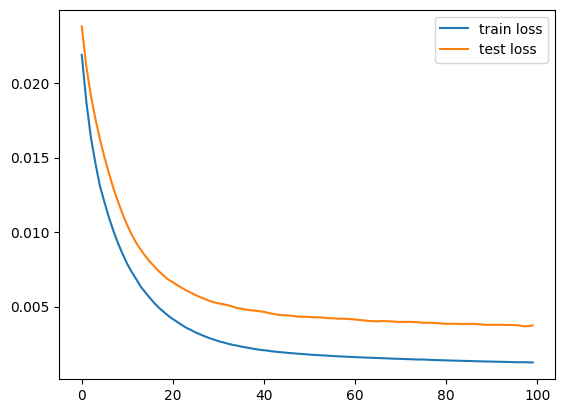

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [ ]:
train_idx[:T+1] = False

In [ ]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 127ms/step


In [ ]:
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

<Axes: xlabel='Month'>

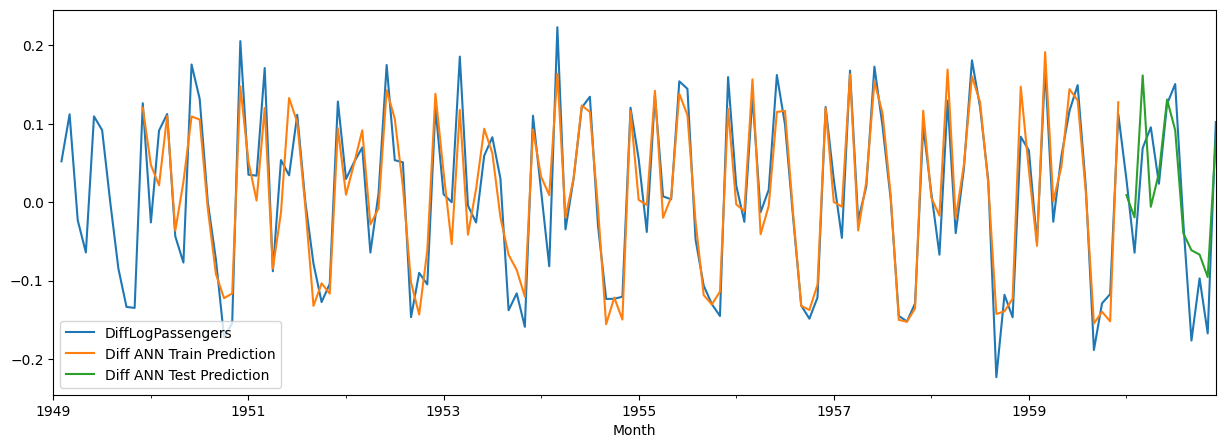

In [ ]:
cols = ['DiffLogPassengers', 'Diff ANN Train Prediction', 'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5))

In [ ]:
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [ ]:
last_train = train.iloc[-1]['LogPassengers']

In [ ]:
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

<Axes: xlabel='Month'>

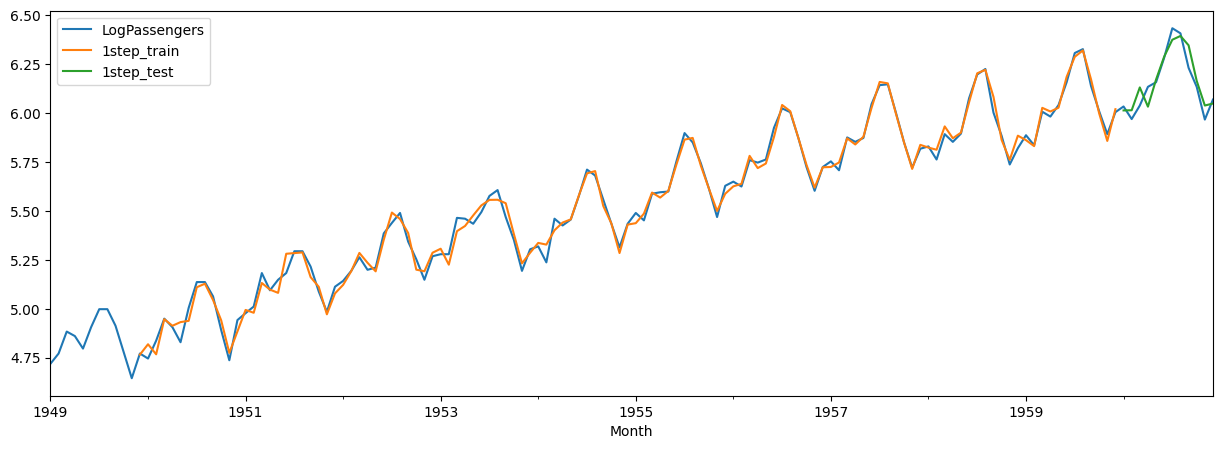

In [ ]:
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5))

In [ ]:
multistep_predictions = []

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]

  multistep_predictions.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 24ms/step


<ipython-input-24-3e19d9b0eb3b>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 [==============================] - 0s 25ms/step


In [ ]:
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

<Axes: xlabel='Month'>

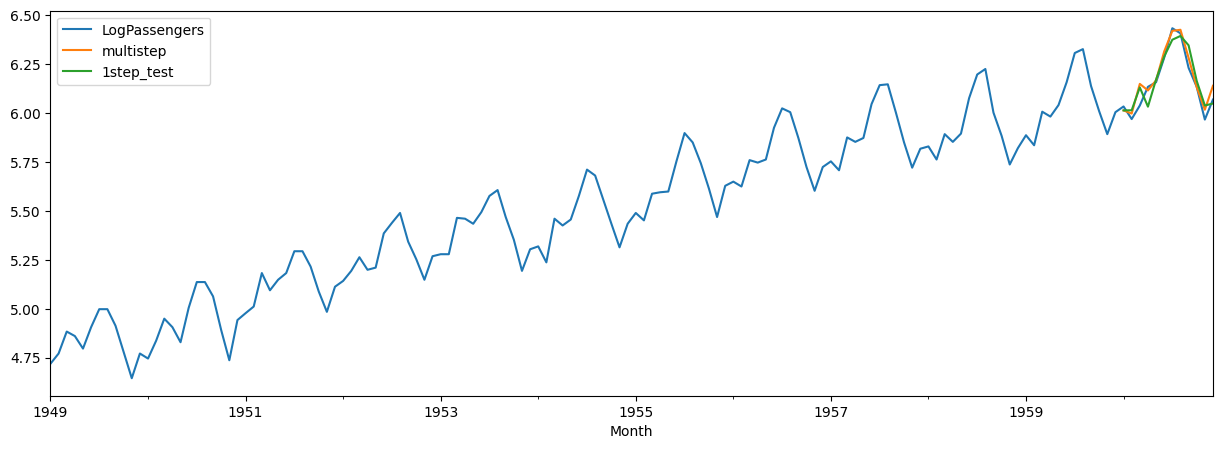

In [ ]:
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5))

In [ ]:
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [ ]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [ ]:
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
r = model.fit(Xtrain_m, Ytrain_m, epochs=100, validation_data=(Xtest_m, Ytest_m))

Epoch 1/100
4/4 [==============================] - 1s 63ms/step - loss: 0.0157 - val_loss: 0.0090
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0146 - val_loss: 0.0085
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0136 - val_loss: 0.0083
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0128 - val_loss: 0.0082
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0122 - val_loss: 0.0080
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0116 - val_loss: 0.0079
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0111 - val_loss: 0.0078
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0107 - val_loss: 0.0075
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0099 - val_loss: 0.0071
Epoch 11/100
4/4 [=

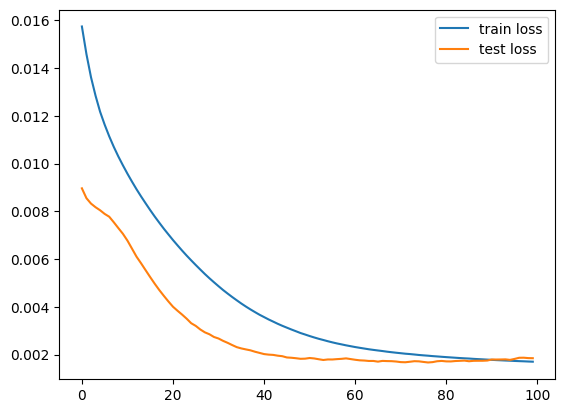

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 25ms/step


In [ ]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [ ]:
Ptrain = Ptrain[:, 0]
Ptest = Ptest[0]

In [ ]:
df.loc[test_idx, 'multioutput'] = last_train + \
np.cumsum(Ptest)

<Axes: xlabel='Month'>

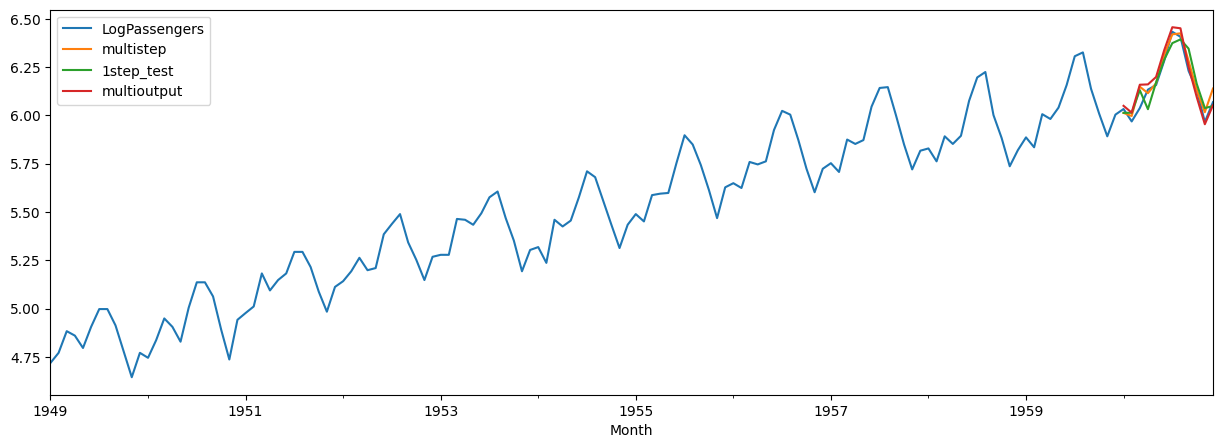

In [ ]:
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5))

In [ ]:
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print('multi-step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print('multi-output MAPE:', mape2)

multi-step MAPE: 0.005793248003732167
multi-output MAPE: 0.006256970884325871
